In [9]:
import torch
import torch.nn as nn
import pandas as pd
from Bio import SeqIO
import os

# Hyperparameters
batch_size = 16
hidden_size = 16
learning_rate = 1e-3
training_steps = 500
input_length_gen = 5  # One-hot encoding size for A, T, C, G, N
input_length_dis = 4
seq_length = 300

class Generator(nn.Module):
    def __init__(self, input_length_gen, hidden_size, seq_length):
        super().__init__()
        self.lstm = nn.LSTM(input_length_gen, hidden_size, batch_first=True)
        self.dense_layer = nn.Linear(hidden_size, 4)
        self.activation = nn.Softmax(dim=2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.dense_layer(lstm_out)
        return self.activation(output)

In [10]:
import torch
import pandas as pd
from Bio import SeqIO
import os

# Hyperparameters
batch_size = 16
seq_length = 300

# Directories containing the CSV files and corresponding FASTA files
traces_dir = 'traces'
fasta_dir = 'fasta_files'

# Lists to store the data
chromatogram_list = []
sequence_list = []

# One-hot encoding mapping
nucleotide_mapping = {'A': [1, 0, 0, 0, 0], 'T': [0, 1, 0, 0, 0], 'C': [0, 0, 1, 0, 0], 'G': [0, 0, 0, 1, 0], 'N': [0, 0, 0, 0, 1]}

# Iterate through the CSV files in the traces folder
for chromatogram_file in os.listdir(traces_dir):
    chromatogram_path = os.path.join(traces_dir, chromatogram_file)
    chromatogram_data = pd.read_csv(chromatogram_path).values[:seq_length]

    # Check if chromatogram data is empty and continue to the next file if so
    if chromatogram_data.size == 0:
        print(f"Ignoring empty chromatogram file {chromatogram_path}")
        continue

    normalized_chromatogram_data = torch.tensor(chromatogram_data / chromatogram_data.max()).float()

    # Construct the corresponding FASTA file path
    sequence_name = os.path.splitext(chromatogram_file)[0]
    fasta_path = os.path.join(fasta_dir, sequence_name + '.fasta')

    # Read the sequence from the corresponding FASTA file
    matching_sequence = str(list(SeqIO.parse(fasta_path, "fasta"))[0].seq)[:seq_length]

    # Check if sequence is empty and continue to the next file if so
    if not matching_sequence:
        print(f"Ignoring empty sequence in file {fasta_path}")
        continue

    # One-hot encode the sequence
    one_hot_sequence = torch.tensor([nucleotide_mapping[n] for n in matching_sequence]).float()

    # Add data to lists
    chromatogram_list.append(normalized_chromatogram_data)
    sequence_list.append(one_hot_sequence)

# Concatenate the data and split into batches
normalized_chromatogram_data = torch.stack(chromatogram_list).split(batch_size)
one_hot_sequences = torch.stack(sequence_list).split(batch_size)

Ignoring empty chromatogram file traces/X09140N00-01.csv


In [23]:
import torch
# Load the generator's parameters
def load_generator(step):
    model = Generator(input_length_gen, hidden_size, seq_length)
    model.load_state_dict(torch.load(f'generator_step_{step}.pth'))
    model.eval()
    return model

# Example: Load the generator after the zeroth step
g_zeroth_step = load_generator(8)

In [24]:
g_zeroth_step

Generator(
  (lstm): LSTM(5, 16, batch_first=True)
  (dense_layer): Linear(in_features=16, out_features=4, bias=True)
  (activation): Softmax(dim=2)
)

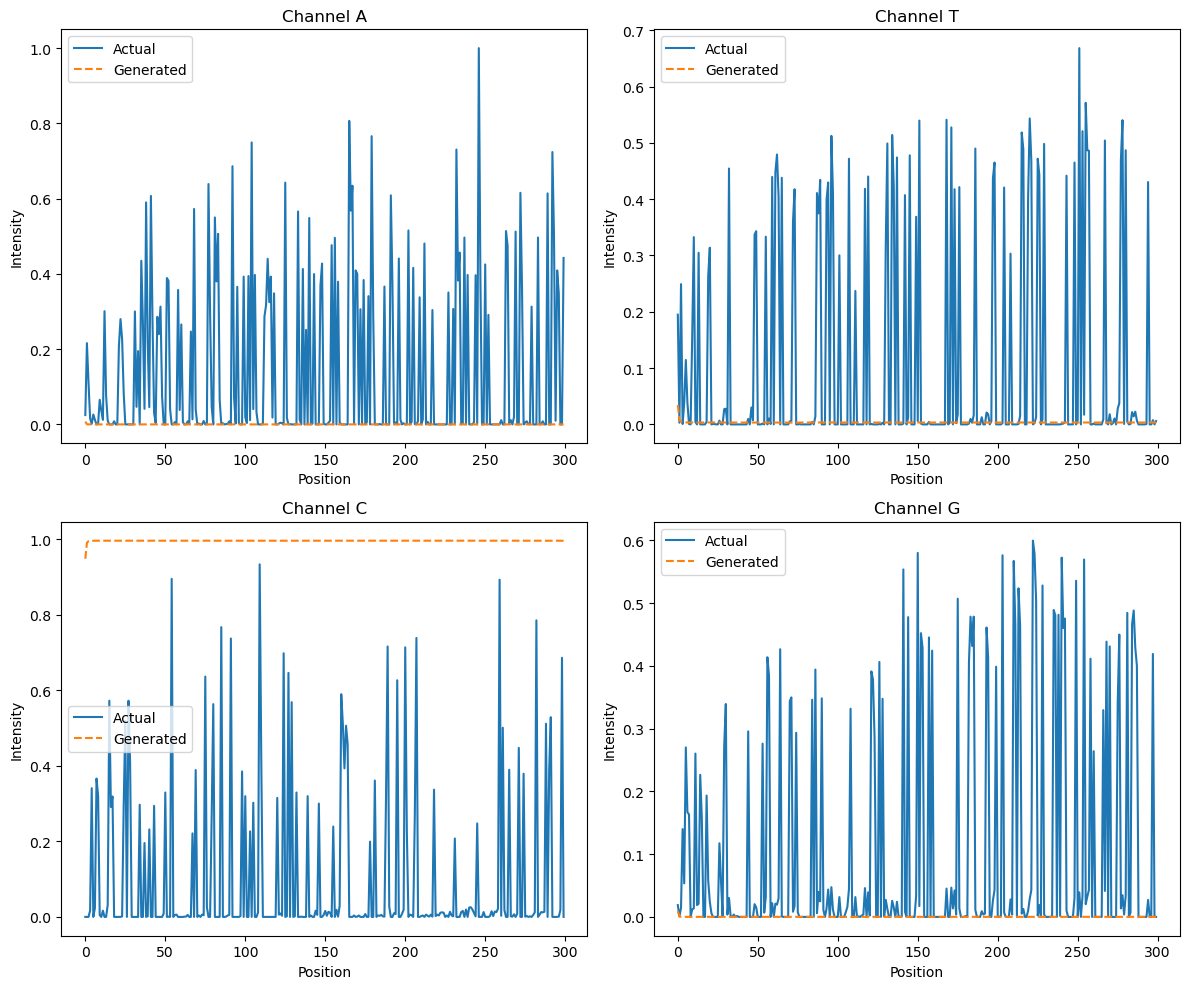

In [28]:
import matplotlib.pyplot as plt

def plot_chromatogram_by_channel(generator, one_hot_sequence, actual_chromatogram):
    with torch.no_grad():
        generated_data = generator(one_hot_sequence.unsqueeze(0)).squeeze(0).numpy()

    nucleotide_channels = ['A', 'T', 'C', 'G']
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, channel in enumerate(nucleotide_channels):
        ax = axes[i]
        ax.plot(actual_chromatogram[:, i], label='Actual')
        ax.plot(generated_data[:, i], label='Generated', linestyle='dashed')
        ax.set_title(f'Channel {channel}')
        ax.set_xlabel('Position')
        ax.set_ylabel('Intensity')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Example: Plot the chromatogram for the first sequence in the dataset using the zeroth-step generator
plot_chromatogram_by_channel(g_zeroth_step, one_hot_sequences[0][0], normalized_chromatogram_data[0][0])

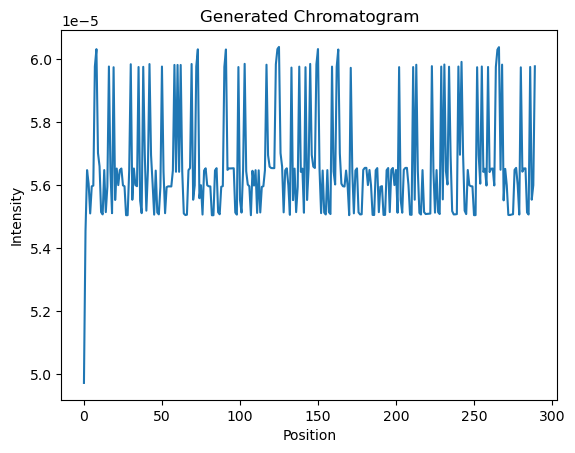

In [26]:
# Load new example
example_chromatogram_data = pd.read_csv('test_case/X09140N00.csv').values[:seq_length]
normalized_example_chromatogram_data = torch.tensor(example_chromatogram_data / example_chromatogram_data.max()).float()

example_sequence = str(list(SeqIO.parse('test_case/X09140N00.fasta', "fasta"))[0].seq)[:seq_length]
one_hot_example_sequence = torch.tensor([nucleotide_mapping[n] for n in example_sequence]).float()

# Plot the generated chromatogram using the zeroth-step generator
plot_chromatogram(g_zeroth_step, one_hot_example_sequence)